In [3]:
from ay_torch import *
import os
%matplotlib widget

In [4]:
from cnn_sqptn1_1 import SqPtn1Dataset
# root='data_generated/sqptn1/'
root='data_generated/sqptn1l/'  #Large dataset size

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        #torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='eval':
    return torchvision.transforms.Compose([
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        #torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
      ])

In [7]:
dset_train= SqPtn1Dataset(root=root, transform=GetDataTransforms('train'), train=True)
dset_test= SqPtn1Dataset(root=root, transform=GetDataTransforms('eval'), train=False)
#NOTE: Adjust the batch and epoch sizes.
# n_batch= 10
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [8]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1])
#print('dset_train[0][0] value:',dset_train[0][0][:,100:110,100:110])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1])
print('dset_test[0][0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 4000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_train[0] label value: tensor([0.9576])
dset_train[0][0] value range: tensor(0.) tensor(1.)
dset_test size: 2000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_test[0] label value: tensor([0.3696])
dset_test[0][0] value range: tensor(0.) tensor(1.)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
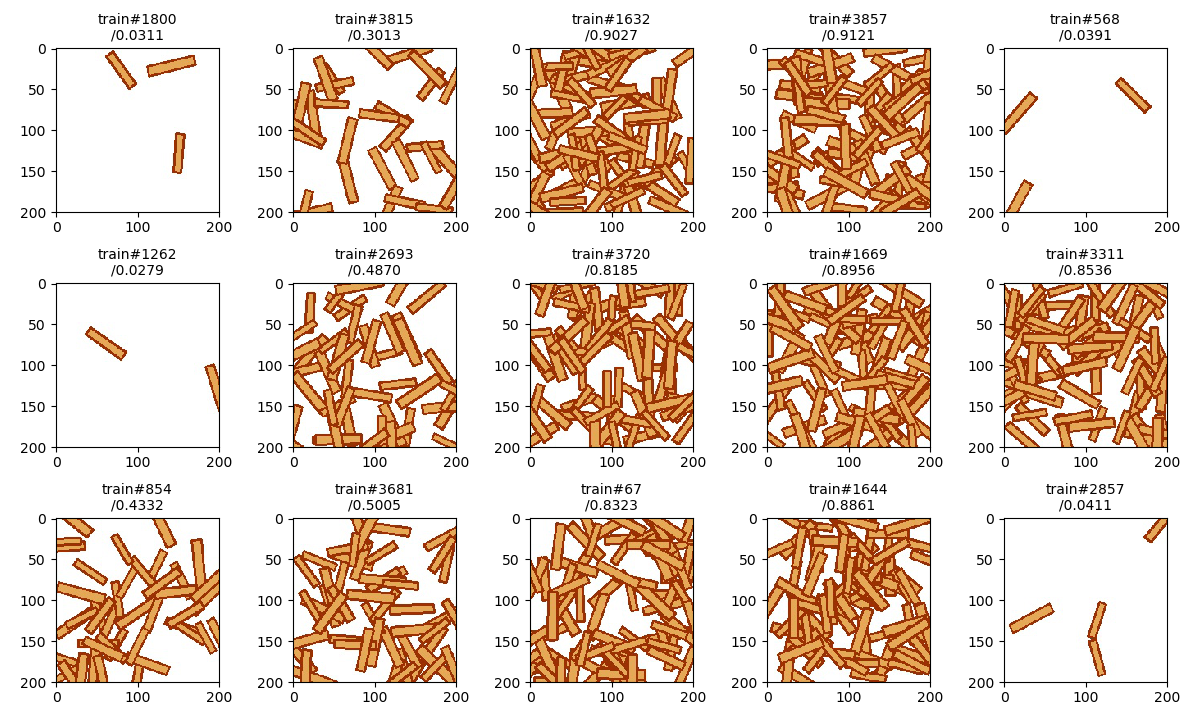

In [9]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d[i][1].item():.4f}' for i in idxes]
PlotImgGrid(imgs, labels)

In [10]:
class TAlexNet(torch.nn.Module):
  def __init__(self, img_shape, p_dropout=0.02):
    super(TAlexNet,self).__init__()
    self.net_features= torch.nn.Sequential(
          #torch.nn.Conv2d(in_channels, out_channels, ...)
          torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          )
    n_feat_out= self.net_features(torch.FloatTensor(*((1,)+img_shape))).view(1,-1).shape[1]
    self.net_estimator= torch.nn.Sequential(
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(n_feat_out, 4096),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(4096, 4096),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(4096, 1)
          )

  def forward(self, x):
    x= self.net_features(x)
    x= x.view(x.size(0), -1)
    return self.net_estimator(x)

In [11]:
#Setup a neural network.
net= TAlexNet(img_shape=dset_train[0][0].shape)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 200, 200)


Layer (type:depth-idx)                   Output Shape              Param #
TAlexNet                                 --                        --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 49, 49]           23,296
│    └─ReLU: 2-2                         [1, 64, 49, 49]           --
│    └─MaxPool2d: 2-3                    [1, 64, 24, 24]           --
│    └─Conv2d: 2-4                       [1, 192, 24, 24]          307,392
│    └─ReLU: 2-5                         [1, 192, 24, 24]          --
│    └─MaxPool2d: 2-6                    [1, 192, 12, 12]          --
│    └─Conv2d: 2-7                       [1, 384, 12, 12]          663,936
│    └─ReLU: 2-8                         [1, 384, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 256, 12, 12]          884,992
│    └─ReLU: 2-10                        [1, 256, 12, 12]          --
│    └─Conv2d: 2-11                      [1, 256, 12, 12]         

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
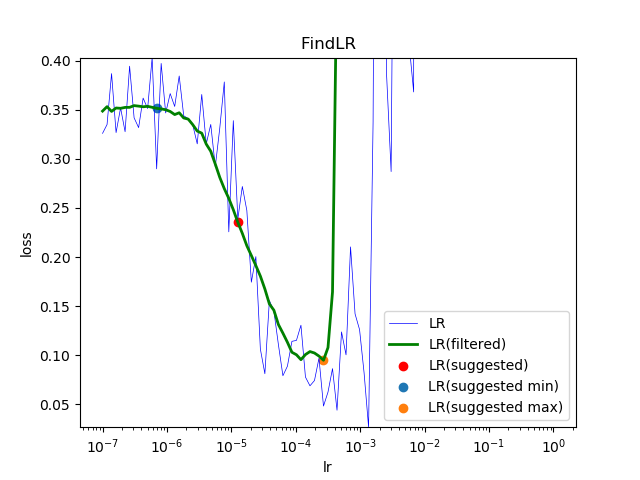

lr= 1.258925411794167e-05, lr_min=6.918309709189364e-07, lr_max=0.0002691534803926915


In [13]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
50	0.00027002	0.00076346	0.02738508	4.988401
51	0.00036615	0.00073346	0.02688363	5.308055
52	0.00116457	0.00163717	0.04004571	5.023092
53	0.00200970	0.00089945	0.02970114	5.339348
54	0.00053340	0.00091043	0.02994414	5.306678
55	0.00044676	0.00074232	0.02702068	4.894697
56	0.00032883	0.00074136	0.02702888	5.333823
57	0.00022259	0.00076241	0.02735908	4.988122
58	0.00018221	0.00074058	0.02698913	5.282429
59	0.00016484	0.00074280	0.02703250	5.364667


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
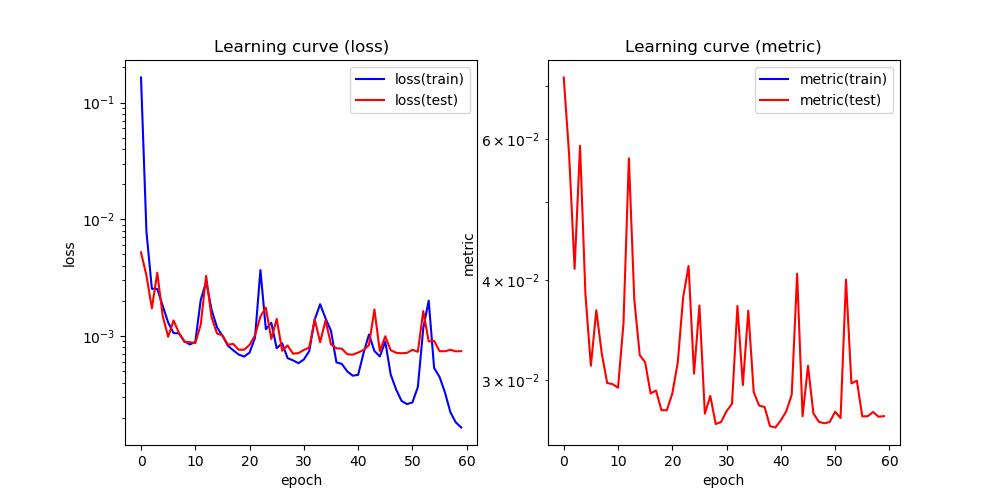

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
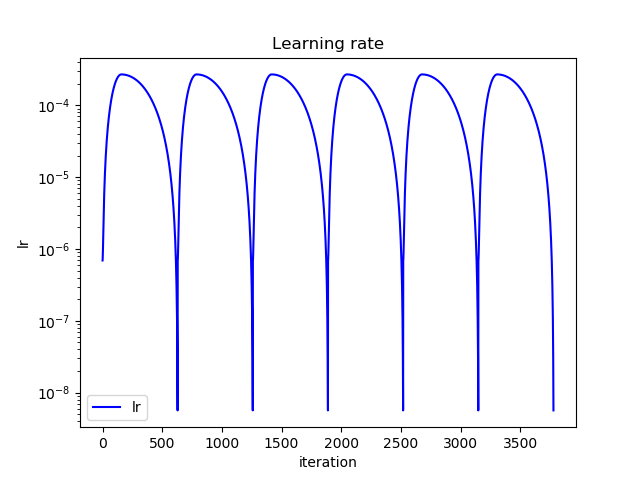

In [19]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
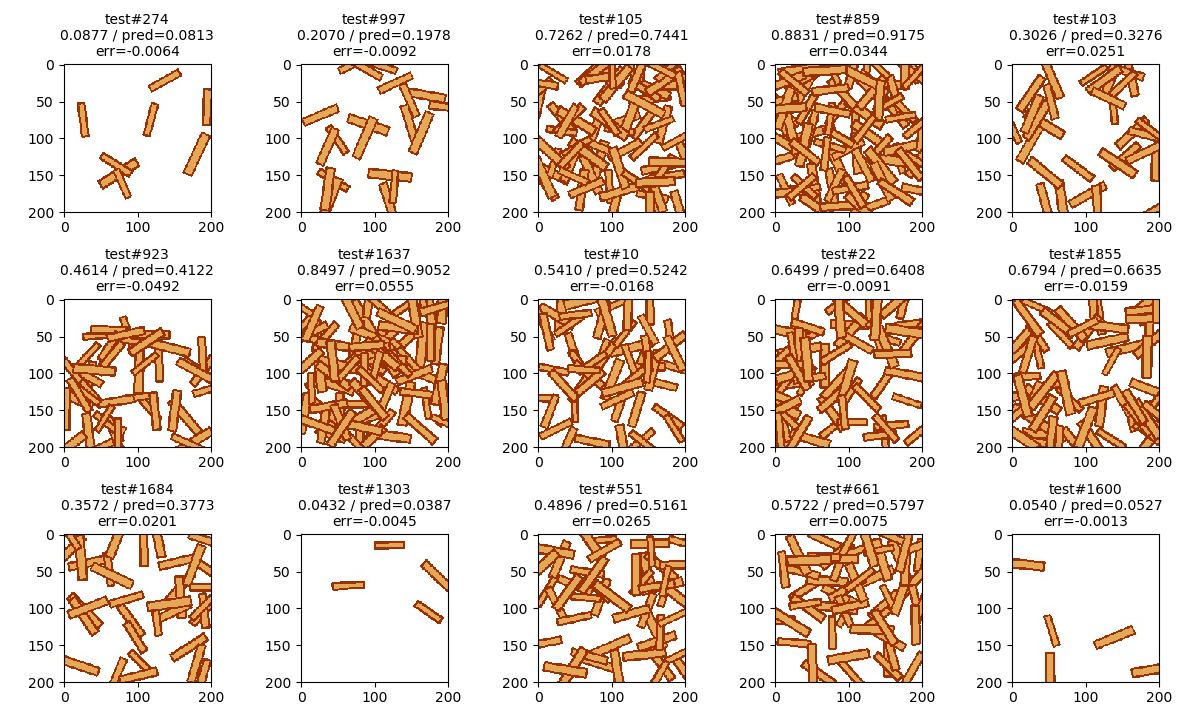

In [20]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d[i][1].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][1].item():.4f}' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

# Smaller batch size

In [22]:
dset_train= SqPtn1Dataset(root=root, transform=GetDataTransforms('train'), train=True)
dset_test= SqPtn1Dataset(root=root, transform=GetDataTransforms('eval'), train=False)
#NOTE: Adjust the batch and epoch sizes.
n_batch= 10
# n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [25]:
class TAlexNet(torch.nn.Module):
  def __init__(self, img_shape, p_dropout=0.02):
    super(TAlexNet,self).__init__()
    self.net_features= torch.nn.Sequential(
          #torch.nn.Conv2d(in_channels, out_channels, ...)
          torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          )
    n_feat_out= self.net_features(torch.FloatTensor(*((1,)+img_shape))).view(1,-1).shape[1]
    self.net_estimator= torch.nn.Sequential(
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(n_feat_out, 4096),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=p_dropout),
          torch.nn.Linear(4096, 4096),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(4096, 1)
          )

  def forward(self, x):
    x= self.net_features(x)
    x= x.view(x.size(0), -1)
    return self.net_estimator(x)

In [26]:
#Setup a neural network.
net= TAlexNet(img_shape=dset_train[0][0].shape)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [27]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 200, 200)


Layer (type:depth-idx)                   Output Shape              Param #
TAlexNet                                 --                        --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 49, 49]           23,296
│    └─ReLU: 2-2                         [1, 64, 49, 49]           --
│    └─MaxPool2d: 2-3                    [1, 64, 24, 24]           --
│    └─Conv2d: 2-4                       [1, 192, 24, 24]          307,392
│    └─ReLU: 2-5                         [1, 192, 24, 24]          --
│    └─MaxPool2d: 2-6                    [1, 192, 12, 12]          --
│    └─Conv2d: 2-7                       [1, 384, 12, 12]          663,936
│    └─ReLU: 2-8                         [1, 384, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 256, 12, 12]          884,992
│    └─ReLU: 2-10                        [1, 256, 12, 12]          --
│    └─Conv2d: 2-11                      [1, 256, 12, 12]         

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
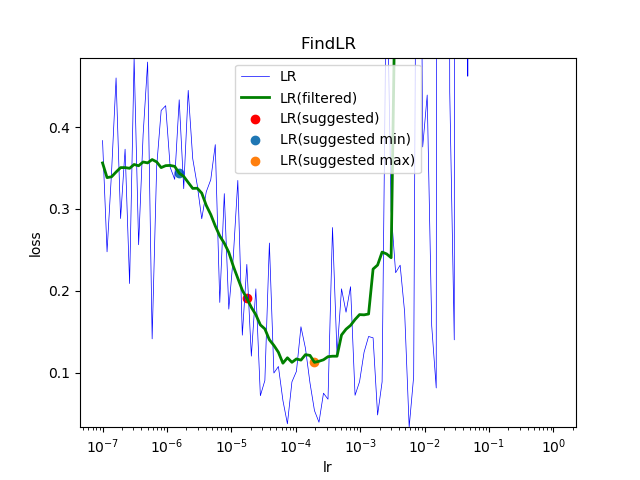

lr= 1.7378008287493757e-05, lr_min=1.5488166189124815e-06, lr_max=0.00019498445997580445


In [28]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
40	0.00018212	0.00080377	0.02719300	14.647352
41	0.00045478	0.00116394	0.03256762	13.318998
42	0.00081639	0.00116936	0.03277175	9.136015
43	0.00057505	0.00082705	0.02757981	9.141255
44	0.00055155	0.00140235	0.03597998	8.988080
45	0.00041397	0.00081321	0.02725965	9.117638
46	0.00022767	0.00076552	0.02645600	8.996416
47	0.00016634	0.00075829	0.02640356	9.166872
48	0.00012701	0.00075993	0.02645612	9.009894
49	0.00010659	0.00075386	0.02632977	9.202821


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
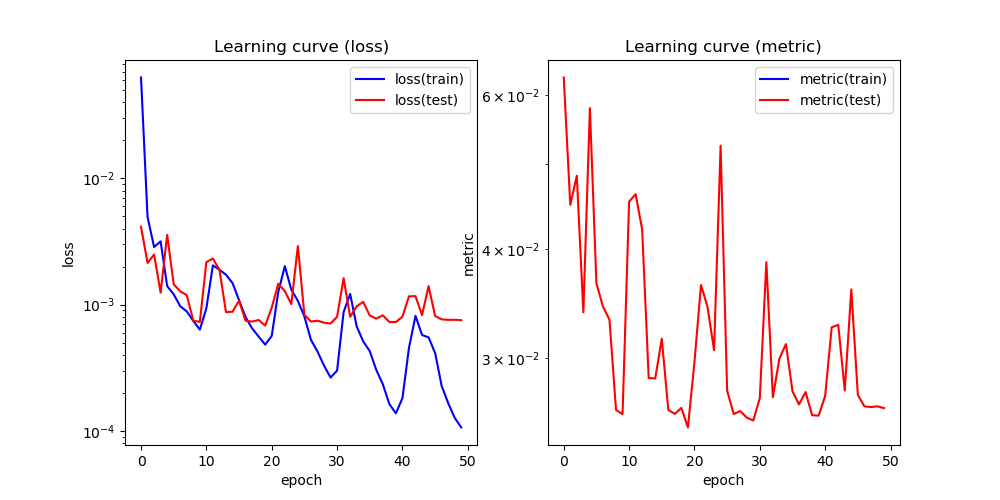

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
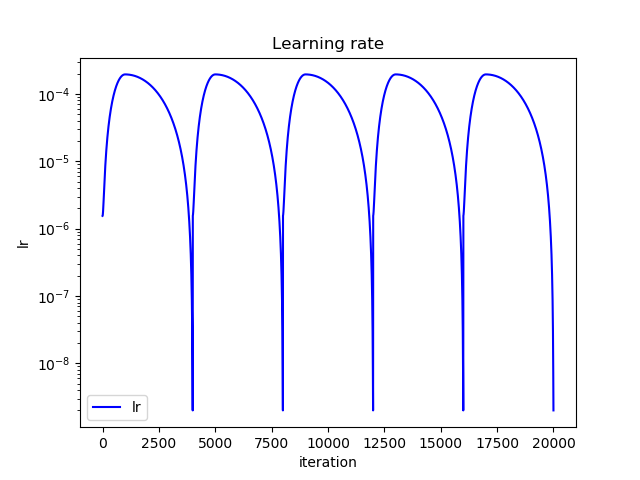

In [33]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()